In [1]:
import os, sys

# Define o caminho absoluto da raiz do projeto
project_root = r"c:\Users\vanma\OneDrive\Documentos\UPE\Projeto\reconhecimento-padroes"

# Só adiciona o diretório do projeto, sem remover outros paths do ambiente
if project_root not in sys.path:
    sys.path.append(project_root)

print("✅ Caminhos ativos (últimos 3):")
for p in sys.path[-3:]:
    print("  ", p)


✅ Caminhos ativos (últimos 3):
   c:\Users\vanma\OneDrive\Documentos\UPE\Projeto\reconhecimento-padroes\.venv\Lib\site-packages\win32\lib
   c:\Users\vanma\OneDrive\Documentos\UPE\Projeto\reconhecimento-padroes\.venv\Lib\site-packages\Pythonwin
   c:\Users\vanma\OneDrive\Documentos\UPE\Projeto\reconhecimento-padroes


In [3]:
from src.data_processing import load_data, preprocess_data
from src.pca_analysis import apply_pca
from src.model_random_forest import(
    RFConfig, evaluate_rf_no_pca, evaluate_rf_with_pca
)

# 1 - Dados
X_train, X_test, y_train, y_test = load_data()
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

# 2 - PCA (k=7; você pode testar 5...10)
X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, n_components=7, plot_variance=False)

In [4]:
cfg = RFConfig(
    n_estimators=300,
    max_depth=None,          # depois testamos limitar
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

metrics_no_pca  = evaluate_rf_no_pca(X_train_scaled, X_test_scaled, y_train, y_test, cfg)

metrics_with_pca = evaluate_rf_with_pca(X_train_pca, X_test_pca, y_train, y_test, cfg)

metrics_no_pca, metrics_with_pca


({'accuracy': 0.9473684210526315,
  'precision': 0.9583333333333334,
  'recall': 0.9583333333333334,
  'f1': 0.9583333333333334,
  'confusion_matrix': [[39, 3], [3, 69]],
  'settings': 'no_pca'},
 {'accuracy': 0.9210526315789473,
  'precision': 0.9436619718309859,
  'recall': 0.9305555555555556,
  'f1': 0.9370629370629371,
  'confusion_matrix': [[38, 4], [5, 67]],
  'settings': 'with_pca',
  'pca_n_components': 7})

In [6]:
import pandas as pd

df_compare = pd.DataFrame([metrics_no_pca, metrics_with_pca])
df_compare = df_compare[["accuracy", "precision", "recall", "f1", "pca_n_components"]]
df_compare


,accuracy,precision,recall,f1,pca_n_components
0,0.947368,0.958333,0.958333,0.958333,NaN
1,0.921053,0.943662,0.930556,0.937063,7.0


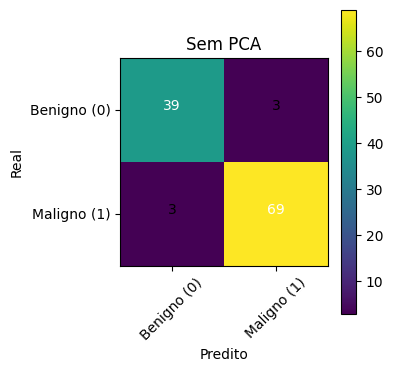

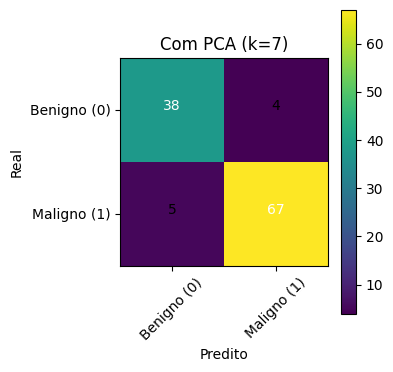

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion(cm, labels=("Benigno (0)", "Maligno (1)"), title="Matriz de Confusão"):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.tight_layout()

plot_confusion(np.array(metrics_no_pca["confusion_matrix"]), title="Sem PCA")
plot_confusion(np.array(metrics_with_pca["confusion_matrix"]), title="Com PCA (k=7)")
plt.show()


In [8]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_rf(X, y, cfg: RFConfig, use_pca=False, n_components=7, n_splits=5):
    # Executa validação cruzada estratificada do Random Forest.
    # Retorna média e descio das métricas.
    from .pca_analysis import apply_pca
    from .data_processing import preprocess_data
    from sklearn.utils import shuffle

    X, y = shuffle(X, y, random_state=cfg.random_state)

    skf = StratifieldKFold(n_splits=n_splits, shuffle=True, random_state=cfg.random_state)
    results = {"accuracy": [], "precision": [], "recall": [], "f1": []}

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Padroniza
        X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

        # PCA
        if use_pca:
            X_train_scaled, X_test_scaled, _ = apply_pca(
                X_train_scaled, X_test_scaled, n_components=n_components, plot_variance=False
            )
        
        # Treina e avalia
        model = build_rf(cfg)
        y_pred = fit_predict(model, X_train_scaled, y_train, X_test_scaled)
        metrics = compute_metrics(y_test, y_pred)

        for key in results.keys():
            results[key].append(metrics[key])

    summary = {k: (np.mean(v), np.std(v)) for k, v in results.items()}
    summary["use_pca"] = use_pca
    summary["n_components"] = n_components if use_pca else None
    summary["n_splits"] = n_splits
    return summary

In [9]:
from src.data_processing import load_data
from src.model_random_forest import RFConfig, cross_validate_rf
import numpy as np

X_train, X_test, y_train, y_test = load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

cfg = RFConfig(n_estimators=300, max_features="sqrt", random_state=42)

cv_no_pca  = cross_validate_rf(X, y, cfg, use_pca=False, n_splits=5)
cv_with_pca = cross_validate_rf(X, y, cfg, use_pca=True, n_components=7, n_splits=5)

cv_no_pca, cv_with_pca


({'accuracy': (np.float64(0.9578636857630801),
   np.float64(0.017848726351172715)),
  'precision': (np.float64(0.9640505686491393),
   np.float64(0.013536114326379552)),
  'recall': (np.float64(0.9693270735524256), np.float64(0.026980956019484248)),
  'f1': (np.float64(0.9664275454860058), np.float64(0.01438314050764051)),
  'use_pca': False,
  'n_components': None,
  'n_splits': 5,
  'raw_results': {'accuracy': [0.9473684210526315,
    0.9298245614035088,
    0.9649122807017544,
    0.9649122807017544,
    0.9823008849557522],
   'precision': [0.9583333333333334,
    0.9571428571428572,
    0.9466666666666667,
    0.9855072463768116,
    0.9726027397260274],
   'recall': [0.9583333333333334,
    0.9305555555555556,
    1.0,
    0.9577464788732394,
    1.0],
   'f1': [0.9583333333333334,
    0.9436619718309859,
    0.9726027397260274,
    0.9714285714285714,
    0.9861111111111112]}},
 {'accuracy': (np.float64(0.9525850023288308),
   np.float64(0.015230419738143205)),
  'precision': (

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Organiza os dados
def build_cv_dataframe(cv_no_pca, cv_with_pca):
    data = []
    for model_name, cv in [("Sem PCA", cv_no_pca), ("Com PCA", cv_with_pca)]:
        for metric, values in cv["raw_results"].items():
            for val in values:
                data.append({"Modelo": model_name, "Métrica": metric.capitalize(), "Valor": val})
    return pd.DataFrame(data)

df_cv = build_cv_dataframe(cv_no_pca, cv_with_pca)
display(df_cv.head())


,Modelo,Métrica,Valor
0,Sem PCA,Accuracy,0.947368
1,Sem PCA,Accuracy,0.929825
2,Sem PCA,Accuracy,0.964912
3,Sem PCA,Accuracy,0.964912
4,Sem PCA,Accuracy,0.982301


<Figure size 1000x600 with 0 Axes>

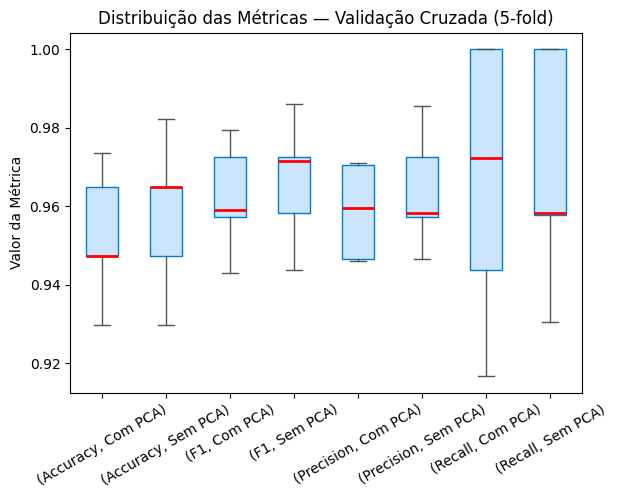

In [11]:
plt.figure(figsize=(10, 6))
ax = df_cv.boxplot(by=["Métrica", "Modelo"], column="Valor", grid=False, patch_artist=True,
                   boxprops=dict(facecolor="#cce5ff", color="#007acc"),
                   medianprops=dict(color="red", linewidth=2),
                   whiskerprops=dict(color="#555555"),
                   capprops=dict(color="#555555"))

plt.suptitle("")  # remove o título automático do pandas
plt.title("Distribuição das Métricas — Validação Cruzada (5-fold)")
plt.xlabel("")
plt.ylabel("Valor da Métrica")
plt.xticks(rotation=30)
plt.show()


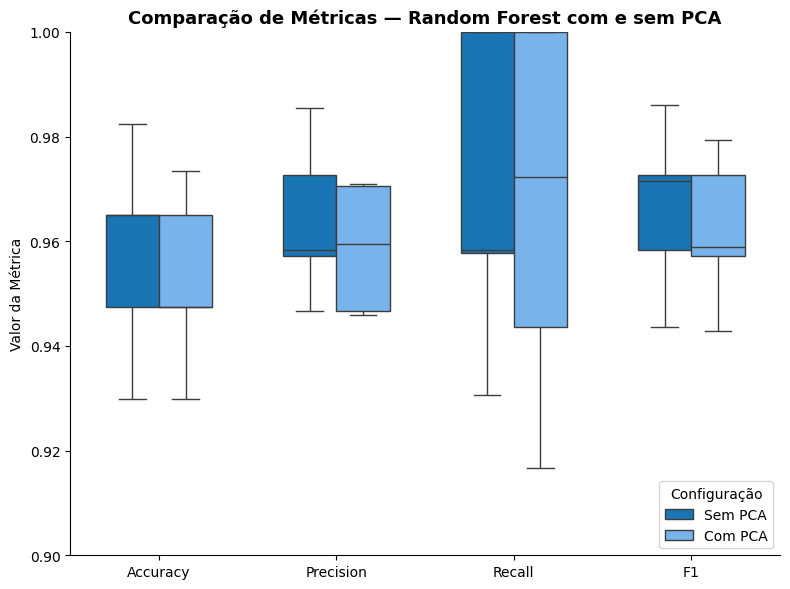

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(data=df_cv, x="Métrica", y="Valor", hue="Modelo",
            palette={"Sem PCA":"#007acc", "Com PCA":"#66b3ff"}, width=0.6)

plt.title("Comparação de Métricas — Random Forest com e sem PCA", fontsize=13, weight="bold")
plt.ylabel("Valor da Métrica")
plt.xlabel("")
plt.ylim(0.9, 1.0)
plt.legend(title="Configuração", loc="lower right")
sns.despine()
plt.tight_layout()
plt.show()
